# TD1 – Kppv et réseaux de neurones pour la classification d'images

L’objectif de ce TD est d'implémenter un programme Python complet de classification d'images. Deux modèles de classification seront abordés : les k-plus-proches-voisins (kppv) et les réseaux de neurones (RNN). Les module numpy et scikit image seront utilisés, respectivement pour la manipulation des matrices et la manipulation des images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from kppv import *
from skimage.feature import hog
from skimage import data, exposure
rng = np.random.default_rng()
from sklearn.metrics import confusion_matrix
import itertools
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.feature import local_binary_pattern
np.random.seed(1) # pour que l'exécution soit déterministe

# K-Plus-Proche-Voisins (KPPV)

On s'intéresse aux modèles de classification basé sur l'algorithme des K-Plus-Proches-Voisins. On commence par définir quelques fonctions permettant de récupérer, nettoyer et séparer les données entrantes.

In [2]:
FILES = [
    './cifar-10-batches-py/data_batch_1',
    './cifar-10-batches-py/data_batch_2',
    './cifar-10-batches-py/data_batch_3',
    './cifar-10-batches-py/data_batch_4',
    './cifar-10-batches-py/data_batch_5',
    './cifar-10-batches-py/test_batch',
]

def unpickle(filename):
    import pickle
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def read_cifar(short=False):
    data, labels = None, None
    for filename in FILES:
        extracted_file = unpickle(filename)
        local_data, local_labels = np.array(extracted_file[b'data'], dtype='float32'), np.array(extracted_file[b'labels'], dtype='float32')
        if type(data) == np.ndarray and type(labels) == np.ndarray:
            data, labels = np.vstack((data, local_data)), np.hstack((labels, local_labels))
        else:
            data, labels = local_data, local_labels
            if short:
                return data, labels
    return data, labels

def split_data(data, labels, split=0.8):
    N, D = data.shape
    hstack = np.hstack((data, labels.reshape(-1, 1)))
    rng.shuffle(hstack)
    hstack_app, hstack_test = hstack[:int(split * N), ...], hstack[int(split * N):, ...]
    return hstack_app[:, :D], hstack_app[:, -1], hstack_test[:, :D], hstack_test[:, -1]

def multiple_split_data(data, labels, cv=5):
    N, D = data.shape
    hstack = np.hstack((data, labels.reshape(-1, 1)))
    rng.shuffle(hstack)
    split = int(N / cv)
    hstacks = list()
    for i in range(cv):
        local_hstack = hstack[int(split * i):int(split * (i + 1)), ...]
        local_hstack_data, local_hstack_label = local_hstack[:, :D], local_hstack[:, -1]
        hstacks.append((local_hstack_data, local_hstack_label))
    return hstacks

Ensuite, on définit **kppv_distance**, prenant en argument Xtest et Xapp et renvoyant la matrice des distances entre une matrice A (toutes les données de l'ensemble de test par exemple) et B (toutes les données de l'ensemble d'apprentissage par exemple). La distance euclidienne L2 est utilisée pour évaluer la distance entre les données. Le calcul est réalisé uniquement à l'aide de manipulation de matrices (aucune boucle).

In [3]:
def kppv_distance(A, B, squared=False):
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False: # Remove negative value to avoid computation errors
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

On définit désormais **kppv_predict** prenant en argument Dist, Yapp et K (le nombre de voisins)
et renvoyant le vecteur des classes prédites pour les éléments de Xtest

In [4]:
def kppv_predict(dist, Yapp, k=1000):
    Napp, Ntest = dist.shape
    k_nearest = np.array(Yapp[np.argsort(dist, axis=0)[:k, ...]], dtype='int64')
    y_test = list()
    for i in range(Ntest):
        y_test.append(np.argmax(np.bincount(k_nearest[:, i], minlength=10)))
    return np.array(y_test, dtype='int32')


Afin de pouvoir évaluer la précision de nos modèles, on définit **evaluate_prediction**, prenant en argument Ytest et Ypred et renvoyant le taux de classification (Accuracy), ainsi que **get_accuracy** qui rassemble les différentes étapes du modèles, et renvoie la précision du modèle.

In [5]:
def evaluate_prediction(Ytest, Ypred):
    assert Ytest.size == Ypred.size
    return np.sum(Ytest == Ypred) / Ytest.size # Accuracy

def get_accuracy(data, labels, k, verbose=False):
    Xapp, Yapp, Xtest, Ytest = split_data(data, labels)
    dist = kppv_distance(Xapp, Xtest)
    print(dist.shape, Yapp.shape)
    Ypred = kppv_predict(dist, Yapp, k)
    accuracy = evaluate_prediction(Ytest, Ypred)
    if verbose:
        print(f'KPPV accuracy \033[1m{accuracy:.3%}\033[0m')
    return accuracy

## Descripteurs

On définit des descripteurs (LBP, HOG) pour représenter les images en utilisant le module scikitimage.

In [6]:
def transform_data_to_HOG(data):
    return np.apply_along_axis(transform_image_to_HOG, 1, data)

def transform_image_to_HOG(image_raw):
    # Reshape
    image = image_raw.reshape(32, 32, 3)

    # HOG
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)

    return hog_image.ravel()

In [7]:
def transform_data_to_LBP(data):
    return np.apply_along_axis(transform_image_to_LBP, 1, data)

def transform_image_to_LBP(image_raw):
    # Settings for LBP
    METHOD = 'uniform'
    radius = 3
    n_points = 8 * radius

    # Extract colors
    size = image_raw.size // 3
    image_raw_red = image_raw[:size]
    image_raw_green = image_raw[size: 2 * size]
    image_raw_blue = image_raw[2 * size: 3 * size]

    # grayscale = 0.299red + 0.587green + 0.114blue
    image_raw_gray = 0.299 * image_raw_red + 0.587 * image_raw_green + 0.114 * image_raw_blue

    # Reshape image
    image = image_raw_gray.reshape(32,32)

    # LBP
    lbp = local_binary_pattern(image, n_points, radius, METHOD)

    return lbp.ravel()

On définit **get_cross_accuracy** qui utilise de la validation croisée à N répertoires (N-fold cross-validation) plutôt qu'un découpage en deux sous-ensembles fixes d'apprentissage et de test.

In [8]:
def get_cross_accuracy(data, labels, k, cv=5, verbose=False):
    splits = multiple_split_data(data, labels, cv) # (X, Y)

    # Create all distance matrix for each fold
    # One fold is: all "app" but one "test"
    accuracies = list()
    for i in range(cv):
        xys = [(s[0], s[1]) for j, s in enumerate(splits) if j != i]
        Xapp, Yapp = None, None
        for x, y in xys:
            if type(Xapp) == np.ndarray and type(Yapp) == np.ndarray:
                Xapp, Yapp = np.vstack((Xapp, x)), np.hstack((Yapp, y))
            else:
                Xapp, Yapp = x, y
        # test -> splits[i] and app -> rest
        dist = kppv_distance(Xapp, splits[i][0], k)
        pred = kppv_predict(dist, Yapp, k)
        accuracy = evaluate_prediction(splits[i][1], pred)
        if verbose:
            print(f'\tFold {i + 1} -> accuracy \033[1m{accuracy:.3%}\033[0m')
        accuracies.append(accuracy)
    mean_accuracy = sum(accuracies) / len(accuracies)
    if verbose:
        print(f'Accuracy \033[1m{mean_accuracy:.3%}\033[0m')
    return mean_accuracy

def accuracy_vs_k(data, labels, from_k=1, to_k=50, step=5, verbose=False, use_cross=False, cv=5):
    accuracies = list()
    ks = list(range(from_k, to_k + 1, step))
    for k in ks:
        print(f'### k:{k:3d}')
        if use_cross:
            accuracies.append(get_cross_accuracy(data, labels, k, cv, verbose))
        else:
            accuracies.append(get_accuracy(data, labels, k, verbose))
    plt.plot(ks, accuracies)
    plt.show()

On va désormais réaliser plusieurs expérimentations :
- Faire tourner le modèle pour k allant de 50 à 5000 avec un pas de 50.
- Faire tourner le modèle avec la validation croisée (N-Fold) pour k allant de 1 à 100 avec un pas de 1.
- Faire tourner le modèle avec la validation croisée (N-Fold) pour k allant de 50 à 5000 avec un pas de 50.
- Faire tourner le modèle avec le descripteur LBP et la validation croisée (N-Fold) pour k allant de 1 à 50 avec un pas de 1.
- Faire tourner le modèle avec le descripteur HOG et la validation croisée (N-Fold) pour k allant de 1 à 50 avec un pas de 1.
- Faire tourner le modèle avec le descripteur HOG et la validation croisée (N-Fold) pour k allant de 1 à 100 avec un pas de 10.

### k: 50
(8000, 2000) (8000,)
KPPV accuracy 26.450%
### k:100
(8000, 2000) (8000,)
KPPV accuracy 25.950%
### k:150
(8000, 2000) (8000,)
KPPV accuracy 27.250%
### k:200
(8000, 2000) (8000,)
KPPV accuracy 25.150%
### k:250
(8000, 2000) (8000,)
KPPV accuracy 24.600%
### k:300
(8000, 2000) (8000,)
KPPV accuracy 24.050%
### k:350
(8000, 2000) (8000,)
KPPV accuracy 25.000%
### k:400
(8000, 2000) (8000,)
KPPV accuracy 23.100%
### k:450
(8000, 2000) (8000,)
KPPV accuracy 24.800%
### k:500
(8000, 2000) (8000,)
KPPV accuracy 23.250%
### k:550
(8000, 2000) (8000,)
KPPV accuracy 24.200%
### k:600
(8000, 2000) (8000,)
KPPV accuracy 23.950%
### k:650
(8000, 2000) (8000,)
KPPV accuracy 23.950%
### k:700
(8000, 2000) (8000,)
KPPV accuracy 25.150%
### k:750
(8000, 2000) (8000,)
KPPV accuracy 24.500%
### k:800
(8000, 2000) (8000,)
KPPV accuracy 22.900%
### k:850
(8000, 2000) (8000,)
KPPV accuracy 23.200%
### k:900
(8000, 2000) (8000,)
KPPV accuracy 23.600%
### k:950
(8000, 2000) (8000,)
KPPV accuracy 2

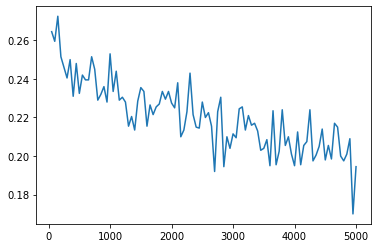

In [30]:
data, labels = read_cifar(short=True)
accuracy_vs_k(data, labels, from_k=50, to_k=5000, step=50, verbose=True, use_cross=False)

### k:  1
	Fold 1 -> accuracy 25.900%
	Fold 2 -> accuracy 29.700%
	Fold 3 -> accuracy 27.800%
	Fold 4 -> accuracy 29.500%
	Fold 5 -> accuracy 29.850%
Accuracy 28.550%
### k:  2
	Fold 1 -> accuracy 27.000%
	Fold 2 -> accuracy 24.500%
	Fold 3 -> accuracy 24.750%
	Fold 4 -> accuracy 26.150%
	Fold 5 -> accuracy 26.750%
Accuracy 25.830%
### k:  3
	Fold 1 -> accuracy 26.300%
	Fold 2 -> accuracy 28.400%
	Fold 3 -> accuracy 27.100%
	Fold 4 -> accuracy 28.750%
	Fold 5 -> accuracy 27.600%
Accuracy 27.630%
### k:  4
	Fold 1 -> accuracy 27.100%
	Fold 2 -> accuracy 28.250%
	Fold 3 -> accuracy 28.550%
	Fold 4 -> accuracy 26.900%
	Fold 5 -> accuracy 27.950%
Accuracy 27.750%
### k:  5
	Fold 1 -> accuracy 27.900%
	Fold 2 -> accuracy 27.100%
	Fold 3 -> accuracy 28.650%
	Fold 4 -> accuracy 28.650%
	Fold 5 -> accuracy 28.550%
Accuracy 28.170%
### k:  6
	Fold 1 -> accuracy 27.950%
	Fold 2 -> accuracy 29.300%
	Fold 3 -> accuracy 27.950%
	Fold 4 -> accuracy 28.750%
	Fold 5 -> accuracy 28.500%
Accuracy 28.490

	Fold 2 -> accuracy 25.650%
	Fold 3 -> accuracy 28.700%
	Fold 4 -> accuracy 28.550%
	Fold 5 -> accuracy 27.600%
Accuracy 27.700%
### k: 40
	Fold 1 -> accuracy 27.900%
	Fold 2 -> accuracy 26.450%
	Fold 3 -> accuracy 27.550%
	Fold 4 -> accuracy 28.600%
	Fold 5 -> accuracy 27.800%
Accuracy 27.660%
### k: 41
	Fold 1 -> accuracy 26.500%
	Fold 2 -> accuracy 29.400%
	Fold 3 -> accuracy 27.400%
	Fold 4 -> accuracy 27.500%
	Fold 5 -> accuracy 27.400%
Accuracy 27.640%
### k: 42
	Fold 1 -> accuracy 26.000%
	Fold 2 -> accuracy 25.850%
	Fold 3 -> accuracy 28.000%
	Fold 4 -> accuracy 28.700%
	Fold 5 -> accuracy 28.500%
Accuracy 27.410%
### k: 43
	Fold 1 -> accuracy 27.700%
	Fold 2 -> accuracy 27.800%
	Fold 3 -> accuracy 27.300%
	Fold 4 -> accuracy 27.200%
	Fold 5 -> accuracy 27.650%
Accuracy 27.530%
### k: 44
	Fold 1 -> accuracy 27.450%
	Fold 2 -> accuracy 28.950%
	Fold 3 -> accuracy 28.350%
	Fold 4 -> accuracy 26.450%
	Fold 5 -> accuracy 26.950%
Accuracy 27.630%
### k: 45
	Fold 1 -> accuracy 26.250

	Fold 3 -> accuracy 27.450%
	Fold 4 -> accuracy 27.350%
	Fold 5 -> accuracy 27.850%
Accuracy 26.920%
### k: 78
	Fold 1 -> accuracy 27.050%
	Fold 2 -> accuracy 25.400%
	Fold 3 -> accuracy 27.650%
	Fold 4 -> accuracy 27.350%
	Fold 5 -> accuracy 27.550%
Accuracy 27.000%
### k: 79
	Fold 1 -> accuracy 26.200%
	Fold 2 -> accuracy 27.500%
	Fold 3 -> accuracy 28.100%
	Fold 4 -> accuracy 26.250%
	Fold 5 -> accuracy 26.350%
Accuracy 26.880%
### k: 80
	Fold 1 -> accuracy 26.400%
	Fold 2 -> accuracy 27.200%
	Fold 3 -> accuracy 26.550%
	Fold 4 -> accuracy 25.450%
	Fold 5 -> accuracy 27.250%
Accuracy 26.570%
### k: 81
	Fold 1 -> accuracy 27.800%
	Fold 2 -> accuracy 26.350%
	Fold 3 -> accuracy 27.200%
	Fold 4 -> accuracy 26.250%
	Fold 5 -> accuracy 25.150%
Accuracy 26.550%
### k: 82
	Fold 1 -> accuracy 26.400%
	Fold 2 -> accuracy 26.700%
	Fold 3 -> accuracy 26.700%
	Fold 4 -> accuracy 26.950%
	Fold 5 -> accuracy 27.150%
Accuracy 26.780%
### k: 83
	Fold 1 -> accuracy 26.250%
	Fold 2 -> accuracy 27.150

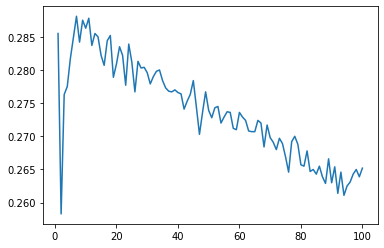

In [31]:
accuracy_vs_k(data, labels, from_k=1, to_k=100, step=1, verbose=True, use_cross=True)

### k: 50
	Fold 1 -> accuracy 27.750%
	Fold 2 -> accuracy 26.000%
	Fold 3 -> accuracy 27.500%
	Fold 4 -> accuracy 28.150%
	Fold 5 -> accuracy 27.450%
Accuracy 27.370%
### k:100
	Fold 1 -> accuracy 25.600%
	Fold 2 -> accuracy 25.900%
	Fold 3 -> accuracy 27.650%
	Fold 4 -> accuracy 25.750%
	Fold 5 -> accuracy 27.450%
Accuracy 26.470%
### k:150
	Fold 1 -> accuracy 25.550%
	Fold 2 -> accuracy 25.950%
	Fold 3 -> accuracy 26.500%
	Fold 4 -> accuracy 27.700%
	Fold 5 -> accuracy 25.350%
Accuracy 26.210%
### k:200
	Fold 1 -> accuracy 26.500%
	Fold 2 -> accuracy 25.500%
	Fold 3 -> accuracy 26.500%
	Fold 4 -> accuracy 24.800%
	Fold 5 -> accuracy 25.100%
Accuracy 25.680%
### k:250
	Fold 1 -> accuracy 26.250%
	Fold 2 -> accuracy 24.450%
	Fold 3 -> accuracy 23.950%
	Fold 4 -> accuracy 25.250%
	Fold 5 -> accuracy 26.500%
Accuracy 25.280%
### k:300
	Fold 1 -> accuracy 25.750%
	Fold 2 -> accuracy 25.000%
	Fold 3 -> accuracy 23.800%
	Fold 4 -> accuracy 25.200%
	Fold 5 -> accuracy 25.150%
Accuracy 24.980

	Fold 1 -> accuracy 20.700%
	Fold 2 -> accuracy 23.550%
	Fold 3 -> accuracy 22.150%
	Fold 4 -> accuracy 22.900%
	Fold 5 -> accuracy 22.900%
Accuracy 22.440%
### k:2000
	Fold 1 -> accuracy 22.800%
	Fold 2 -> accuracy 22.750%
	Fold 3 -> accuracy 24.850%
	Fold 4 -> accuracy 21.550%
	Fold 5 -> accuracy 21.000%
Accuracy 22.590%
### k:2050
	Fold 1 -> accuracy 21.200%
	Fold 2 -> accuracy 24.000%
	Fold 3 -> accuracy 21.900%
	Fold 4 -> accuracy 21.300%
	Fold 5 -> accuracy 22.200%
Accuracy 22.120%
### k:2100
	Fold 1 -> accuracy 20.500%
	Fold 2 -> accuracy 23.200%
	Fold 3 -> accuracy 22.650%
	Fold 4 -> accuracy 22.250%
	Fold 5 -> accuracy 22.600%
Accuracy 22.240%
### k:2150
	Fold 1 -> accuracy 22.000%
	Fold 2 -> accuracy 21.750%
	Fold 3 -> accuracy 22.550%
	Fold 4 -> accuracy 22.150%
	Fold 5 -> accuracy 20.900%
Accuracy 21.870%
### k:2200
	Fold 1 -> accuracy 21.600%
	Fold 2 -> accuracy 21.550%
	Fold 3 -> accuracy 21.750%
	Fold 4 -> accuracy 23.850%
	Fold 5 -> accuracy 23.100%
Accuracy 22.370%
###

	Fold 1 -> accuracy 22.600%
	Fold 2 -> accuracy 21.600%
	Fold 3 -> accuracy 20.400%
	Fold 4 -> accuracy 20.750%
	Fold 5 -> accuracy 18.750%
Accuracy 20.820%
### k:3900
	Fold 1 -> accuracy 20.950%
	Fold 2 -> accuracy 20.300%
	Fold 3 -> accuracy 22.100%
	Fold 4 -> accuracy 21.500%
	Fold 5 -> accuracy 18.650%
Accuracy 20.700%
### k:3950
	Fold 1 -> accuracy 18.750%
	Fold 2 -> accuracy 22.850%
	Fold 3 -> accuracy 21.500%
	Fold 4 -> accuracy 19.050%
	Fold 5 -> accuracy 20.350%
Accuracy 20.500%
### k:4000
	Fold 1 -> accuracy 19.750%
	Fold 2 -> accuracy 21.200%
	Fold 3 -> accuracy 21.100%
	Fold 4 -> accuracy 21.300%
	Fold 5 -> accuracy 20.350%
Accuracy 20.740%
### k:4050
	Fold 1 -> accuracy 21.000%
	Fold 2 -> accuracy 20.250%
	Fold 3 -> accuracy 21.250%
	Fold 4 -> accuracy 20.700%
	Fold 5 -> accuracy 20.300%
Accuracy 20.700%
### k:4100
	Fold 1 -> accuracy 22.350%
	Fold 2 -> accuracy 20.750%
	Fold 3 -> accuracy 20.700%
	Fold 4 -> accuracy 20.150%
	Fold 5 -> accuracy 21.050%
Accuracy 21.000%
###

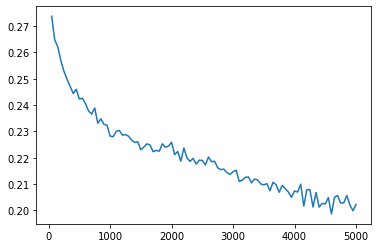

In [32]:
accuracy_vs_k(data, labels, from_k=50, to_k=5000, step=50, verbose=True, use_cross=True)

### k:  1
	Fold 1 -> accuracy 11.650%
	Fold 2 -> accuracy 12.500%
	Fold 3 -> accuracy 12.250%
	Fold 4 -> accuracy 12.650%
	Fold 5 -> accuracy 12.150%
Accuracy 12.240%
### k:  2
	Fold 1 -> accuracy 11.100%
	Fold 2 -> accuracy 9.950%
	Fold 3 -> accuracy 9.100%
	Fold 4 -> accuracy 11.150%
	Fold 5 -> accuracy 11.200%
Accuracy 10.500%
### k:  3
	Fold 1 -> accuracy 11.450%
	Fold 2 -> accuracy 9.600%
	Fold 3 -> accuracy 10.950%
	Fold 4 -> accuracy 9.900%
	Fold 5 -> accuracy 10.350%
Accuracy 10.450%
### k:  4
	Fold 1 -> accuracy 10.250%
	Fold 2 -> accuracy 10.650%
	Fold 3 -> accuracy 11.800%
	Fold 4 -> accuracy 10.950%
	Fold 5 -> accuracy 10.150%
Accuracy 10.760%
### k:  5
	Fold 1 -> accuracy 9.800%
	Fold 2 -> accuracy 10.150%
	Fold 3 -> accuracy 9.500%
	Fold 4 -> accuracy 10.100%
	Fold 5 -> accuracy 11.750%
Accuracy 10.260%
### k:  6
	Fold 1 -> accuracy 9.950%
	Fold 2 -> accuracy 10.850%
	Fold 3 -> accuracy 11.100%
	Fold 4 -> accuracy 9.250%
	Fold 5 -> accuracy 10.000%
Accuracy 10.230%
### k:

	Fold 4 -> accuracy 9.650%
	Fold 5 -> accuracy 10.100%
Accuracy 10.140%
### k: 40
	Fold 1 -> accuracy 10.300%
	Fold 2 -> accuracy 9.600%
	Fold 3 -> accuracy 9.350%
	Fold 4 -> accuracy 10.550%
	Fold 5 -> accuracy 10.550%
Accuracy 10.070%
### k: 41
	Fold 1 -> accuracy 10.350%
	Fold 2 -> accuracy 9.450%
	Fold 3 -> accuracy 10.400%
	Fold 4 -> accuracy 9.750%
	Fold 5 -> accuracy 10.550%
Accuracy 10.100%
### k: 42
	Fold 1 -> accuracy 10.150%
	Fold 2 -> accuracy 10.650%
	Fold 3 -> accuracy 9.700%
	Fold 4 -> accuracy 10.350%
	Fold 5 -> accuracy 10.000%
Accuracy 10.170%
### k: 43
	Fold 1 -> accuracy 10.350%
	Fold 2 -> accuracy 9.700%
	Fold 3 -> accuracy 10.650%
	Fold 4 -> accuracy 9.400%
	Fold 5 -> accuracy 10.500%
Accuracy 10.120%
### k: 44
	Fold 1 -> accuracy 9.750%
	Fold 2 -> accuracy 9.800%
	Fold 3 -> accuracy 10.300%
	Fold 4 -> accuracy 11.400%
	Fold 5 -> accuracy 9.150%
Accuracy 10.080%
### k: 45
	Fold 1 -> accuracy 10.500%
	Fold 2 -> accuracy 9.050%
	Fold 3 -> accuracy 10.100%
	Fold 4 ->

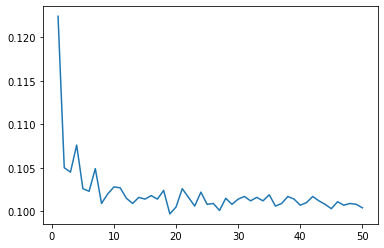

In [33]:
data_lbp = transform_data_to_LBP(data)
accuracy_vs_k(data_lbp, labels, from_k=1, to_k=50, step=1, verbose=True, use_cross=True)

### k:  1
	Fold 1 -> accuracy 20.500%
	Fold 2 -> accuracy 23.350%
	Fold 3 -> accuracy 22.750%
	Fold 4 -> accuracy 22.450%
	Fold 5 -> accuracy 23.600%
Accuracy 22.530%
### k:  2
	Fold 1 -> accuracy 22.450%
	Fold 2 -> accuracy 21.950%
	Fold 3 -> accuracy 20.550%
	Fold 4 -> accuracy 21.950%
	Fold 5 -> accuracy 21.000%
Accuracy 21.580%
### k:  3
	Fold 1 -> accuracy 24.100%
	Fold 2 -> accuracy 22.600%
	Fold 3 -> accuracy 22.250%
	Fold 4 -> accuracy 23.100%
	Fold 5 -> accuracy 22.300%
Accuracy 22.870%
### k:  4
	Fold 1 -> accuracy 23.600%
	Fold 2 -> accuracy 24.950%
	Fold 3 -> accuracy 24.400%
	Fold 4 -> accuracy 24.300%
	Fold 5 -> accuracy 24.600%
Accuracy 24.370%
### k:  5
	Fold 1 -> accuracy 24.300%
	Fold 2 -> accuracy 24.700%
	Fold 3 -> accuracy 24.300%
	Fold 4 -> accuracy 26.200%
	Fold 5 -> accuracy 25.550%
Accuracy 25.010%
### k:  6
	Fold 1 -> accuracy 26.250%
	Fold 2 -> accuracy 24.850%
	Fold 3 -> accuracy 24.100%
	Fold 4 -> accuracy 26.400%
	Fold 5 -> accuracy 27.000%
Accuracy 25.720

	Fold 2 -> accuracy 29.350%
	Fold 3 -> accuracy 30.050%
	Fold 4 -> accuracy 28.250%
	Fold 5 -> accuracy 29.950%
Accuracy 29.690%
### k: 40
	Fold 1 -> accuracy 29.100%
	Fold 2 -> accuracy 29.250%
	Fold 3 -> accuracy 31.150%
	Fold 4 -> accuracy 31.750%
	Fold 5 -> accuracy 29.700%
Accuracy 30.190%
### k: 41
	Fold 1 -> accuracy 29.750%
	Fold 2 -> accuracy 31.250%
	Fold 3 -> accuracy 29.300%
	Fold 4 -> accuracy 30.700%
	Fold 5 -> accuracy 29.550%
Accuracy 30.110%
### k: 42
	Fold 1 -> accuracy 30.400%
	Fold 2 -> accuracy 30.050%
	Fold 3 -> accuracy 29.150%
	Fold 4 -> accuracy 31.600%
	Fold 5 -> accuracy 29.750%
Accuracy 30.190%
### k: 43
	Fold 1 -> accuracy 28.500%
	Fold 2 -> accuracy 31.150%
	Fold 3 -> accuracy 30.200%
	Fold 4 -> accuracy 30.100%
	Fold 5 -> accuracy 29.850%
Accuracy 29.960%
### k: 44
	Fold 1 -> accuracy 31.150%
	Fold 2 -> accuracy 30.000%
	Fold 3 -> accuracy 29.500%
	Fold 4 -> accuracy 31.900%
	Fold 5 -> accuracy 28.350%
Accuracy 30.180%
### k: 45
	Fold 1 -> accuracy 31.200

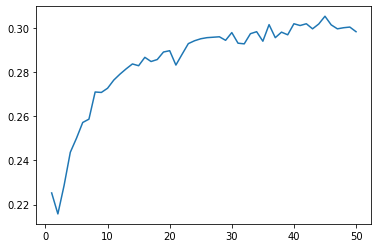

In [34]:
data_hog = transform_data_to_HOG(data)
accuracy_vs_k(data_hog, labels, from_k=1, to_k=50, step=1, verbose=True, use_cross=True)

### k:  1
	Fold 1 -> accuracy 22.250%
	Fold 2 -> accuracy 23.050%
	Fold 3 -> accuracy 22.450%
	Fold 4 -> accuracy 22.700%
	Fold 5 -> accuracy 22.050%
Accuracy 22.500%
### k: 11
	Fold 1 -> accuracy 28.250%
	Fold 2 -> accuracy 27.350%
	Fold 3 -> accuracy 26.900%
	Fold 4 -> accuracy 28.200%
	Fold 5 -> accuracy 27.400%
Accuracy 27.620%
### k: 21
	Fold 1 -> accuracy 28.100%
	Fold 2 -> accuracy 29.550%
	Fold 3 -> accuracy 28.700%
	Fold 4 -> accuracy 29.650%
	Fold 5 -> accuracy 28.800%
Accuracy 28.960%
### k: 31
	Fold 1 -> accuracy 27.900%
	Fold 2 -> accuracy 29.250%
	Fold 3 -> accuracy 30.000%
	Fold 4 -> accuracy 29.500%
	Fold 5 -> accuracy 29.900%
Accuracy 29.310%
### k: 41
	Fold 1 -> accuracy 29.300%
	Fold 2 -> accuracy 30.900%
	Fold 3 -> accuracy 29.550%
	Fold 4 -> accuracy 30.650%
	Fold 5 -> accuracy 31.100%
Accuracy 30.300%
### k: 51
	Fold 1 -> accuracy 29.450%
	Fold 2 -> accuracy 30.900%
	Fold 3 -> accuracy 30.950%
	Fold 4 -> accuracy 29.100%
	Fold 5 -> accuracy 29.450%
Accuracy 29.970

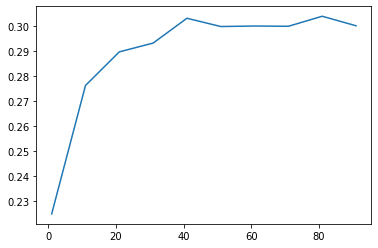

In [35]:
accuracy_vs_k(data_hog, labels, from_k=1, to_k=100, step=10, verbose=True, use_cross=True)

# Réseaux de neurones

On s'intéresse désormais aux modèles de classification basé sur un réseau de neurones. On réutilise les fonctions de lecture et de découpage des données réalisées précédemment. Par ailleurs, commençons par définir les fonctions classiques calculatoires utilisées par la suite. Nous définissons la fonction sigmoid bien que nous n'utiliserons que les fonctions ReLU et softmax, respectivement pour les couches cachées et la couche de sortie. On définit également leur fonction backward correspondantes, qui nous permettront de réaliser la descente du gradient.

In [10]:
def softmax(Z):
    cache = Z
    Z -= np.max(Z)
    sm = (np.exp(Z) / np.sum(np.exp(Z), axis=0))
    return sm, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    assert (A.shape == Z.shape)
    cache = Z
    return A, cache

def softmax_backward(dA, cache):
    z = cache
    z -= np.max(z)
    s = (np.exp(z) / np.sum(np.exp(z), axis=0))
    dZ = dA * s * (1 - s)
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    # When z <= 0, we set dz to 0 as well.
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

## Initialisation
On commence par définir une fonction, qui, à partir d'une liste contenant les dimensions des différentes couches du réseau de neurones, initialisera les paramètres.
On peut noter ici que l'on réalise une initialisation des poids du réseau (matrice W) selon les principes Kaiming / MSRA Initialization. En effet, ce type d'initialisation est plus performante dans le cadre de l'utilisation de fonction ReLU pour les couches cachées du réseau. On initialise les biais (matrice b) comme étant un vecteur nul.

In [11]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)  # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

## Forward propagation
Ensuite on définit 3 fonctions nécessaires à la propagation en avant. Une fonction **linear_forward** effectuant les produits matriciels de la propagation en avant, puis une fonction **linear_activation_forward**, qui, utilisant **linear_forward** effectue la propagation d'une couche à une autre (produit matriciel + fonction d'activation). On a 3 options de fonctions : relu, sigmoid ou softmax. Par la suite nous utiliserons la fonctions **ReLU** pour les couches cachées, et la fonction **softmax** pour générer les probabilités sur la couche de sortie.
Enfin, **L_model_forward** permet de réaliser la propagation à travers toutes les couches, en utilisant **linear_activation_forward**. C'est le seul endroit où un boucle *for* est inévitable.

In [12]:
def batch_normalization(X):
    eps = 1e-7
    var = np.var(X, axis=0, keepdims=True)
    mean = np.mean(X, axis=0, keepdims=True)
    X_n = (X - mean)/np.sqrt(var + eps)
    return X_n

def linear_forward(A, W, b):
    A = batch_normalization(A)
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters, activ_func_hidden, activ_out):
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    for l in range(1, L + 1): # L+1 is pretty important ATTENTION
        A_prev = A
        Wl = parameters['W' + str(l)]
        bl = parameters['b' + str(l)]
        if l < L:
            A, cache = linear_activation_forward(A_prev, Wl, bl, activation=activ_func_hidden)
        else:
            AL, cache = linear_activation_forward(A_prev, Wl, bl, activation=activ_out)
        caches.append(cache)
    return AL, caches


## Fonction de coût
On définit une fonction de coût. On a J = $\frac{-1}{m}$ $\sum_{i=1}^{m} y_i*log(al_i) $ où AL est le vecteur de sortie obtenue lors de la propagation en avant. C'est la fonction de coût dite de 'cross-entropy'

In [13]:
def compute_cost(AL, Y, activation_out, parameters, loss_function, lambda_reg):
    m = Y.shape[1]
    L = len(parameters) // 2
    if loss_function == "mse":
        cost = (1/(2*m))*np.sum(np.square(Y-AL))
        cost = np.squeeze(cost)
    elif loss_function == "cross-entropy":
        if activation_out == "sigmoid":
            cost = (-1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
        elif activation_out == "softmax":
            cost = (-1 / m) * np.sum(Y * np.log(AL))
    reg_cost = 0
    for l in range(1, L):
        reg_cost += np.sum(parameters['W' + str(l)]**2)
    return cost+ lambda_reg*reg_cost/m

## Backward propagation
On définit 3 fonctions nécessaires à la backpropagation. Une fonction **linear_backward** effectuant les produits matriciels de la backpropagation, puis une fonction **linear_activation_backward**, qui, utilisant **linear_backward** propage la backpropagation en fonctione de la fonction d'activation de la couche (utilisation de la fonction backward adéquate).
Les différentes fonctions backward sont définies dans le fichier function.py, afin de ne pas alourdir le propos ici. Elles prennent toutes dA en argument, ainsi que le cache, et retournent dZ.
Enfin, **L_model_backward** permet de réaliser la backpropagation à travers toutes les couches, en utilisant **linear_activation_backward**. C'est le seul endroit où un boucle *for* est inévitable.

In [14]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

def L_model_backward(AL, Y, caches, activ_func_hidden, activ_out, loss_function):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    if loss_function == "cross-entropy":
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    elif loss_function == "mse":
        dAL = AL-Y # derivative of cost with respect to AL
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dAL, caches[L-1], activation=activ_out)  # Softmax or sigmoid, in function of the need
    for l in reversed(range(L-1)):
        grads['dA' + str(l)], grads['dW' + str(l+1)], grads['db' + str(l+1)] = linear_activation_backward(grads['dA' + str(l+1)], caches[l], activation=activ_func_hidden)
    return grads


## Mise à jour des paramètres
Suite à la backpropagation, on définit une fonction pour mettre à jour les paramètres en fonctions des gradients récupérés, des valeurs initiales des paramètres, ainsi que du learning_rate. Ce learning_rate est un hyper-paramètre qu'il nous faudra ajuster par la suite

In [15]:
def adam_grad(grad, beta1, beta2, n_iter): #n_iter is the number of the iteration/ epoch ?
    first_moment = 0
    second_moment = 0
    first_moment = beta1 * first_moment+(1-beta1)*grad
    second_moment = beta2* second_moment + (1-beta2)*grad*grad
    first_unbias = first_moment / (1-beta1**n_iter)
    second_unbias = second_moment / (1-beta2**n_iter)
    return (first_unbias, second_unbias)

def learning_rate_decay(learning_rate_0, n_epoch, N_epoch):
    learning_rate_n = learning_rate_0*(1+np.cos(np.pi*n_epoch/N_epoch))/2  # Commence à 1
    return learning_rate_n


def update_parameters(params, grads, learning_rate, n_epoch, N_epoch, beta1, beta2, learning_r_decay=True, adam=True):
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network
    if learning_r_decay:
        learning_rate_cur = learning_rate_decay(learning_rate, n_epoch, N_epoch)
    else:
        learning_rate_cur = learning_rate
    for l in range(1,L+1):
        if adam:
            first_unbias_w, second_unbias_w = adam_grad(grads['dW' + str(l)], beta1, beta2, n_epoch)
            parameters['W' + str(l)] = parameters['W' + str(l)] -learning_rate*first_unbias_w / (np.sqrt(second_unbias_w)+ 1e-7)
            first_unbias_l, second_unbias_l = adam_grad(grads['db' + str(l)], beta1, beta2, n_epoch)
            parameters['b' + str(l)] = parameters['b' + str(l)] -learning_rate*first_unbias_l / (np.sqrt(second_unbias_l)+ 1e-7)
        else:
            parameters['W' + str(l)] = parameters['W' + str(l)] -learning_rate_cur*grads['dW' + str(l)]
            parameters['b' + str(l)] = parameters['b' + str(l)] -learning_rate_cur*grads['db' + str(l)]
    return parameters

## Modèle complet

In [16]:
# L_layer_model
def L_layer_model(X, Y, parameters, learning_rate, lambda_reg, n_epoch, N_epoch, beta1, beta2, prev_cost,
                  learning_r_dec, adam, activ_func_hidden, activ_out, loss_function, print_error=False):

    costn_1 = prev_cost
    AL, caches = L_model_forward(X, parameters, activ_func_hidden, activ_out)
    cost = compute_cost(AL, Y, activ_out, parameters, loss_function, lambda_reg)
    grads = L_model_backward(AL, Y, caches, activ_func_hidden, activ_out, loss_function)
    parameters = update_parameters(parameters, grads, learning_rate, n_epoch, N_epoch, beta1, beta2, learning_r_dec, adam)

    if print_error & (costn_1 < cost):
        print("Error, Alpha parameter to lessen")

    return parameters, cost

## Fonction d'évaluation de la performance

In [17]:
def evaluate_prediction_rnn(Ypred, Ytest):
    tot_true = np.sum(Ytest==np.array(np.argmax(Ypred, axis=0)))
    return tot_true/Ytest.size

## Tracé de l'apprentissage

In [18]:
def plot_loss_function(cost):
    n_iter = len(cost)
    iter = np.arange(1, n_iter+1)
    plt.plot(iter, cost)
    plt.title("Cost function")
    plt.show()
    
def plot_accuracy(train_accu, test_accu, layers):
    n_iter = len(train_accu)
    iter = np.arange(1, n_iter+1)
    plt.plot(iter, train_accu, "b--", label="Training accuracy")
    plt.plot(iter, test_accu, "r--", label="Test accuracy")
    plt.legend()
    plt.title("Accuracy for layers "+ str(layers))
    plt.show()

In [19]:
# Training the model
def preprocessing(data, labels):
    data = (data - np.mean(data, axis=0, keepdims=True))/np.std(data, axis=0, keepdims=True)
    Xapp, Yapp, Xtest, Ytest = split_data(data, labels)
    X_t = Xapp.T
    Y_t = np.array([Yapp])
    X_te = Xtest.T
    Y_te = np.array([Ytest])
    return (X_t, Y_t, X_te, Y_te)

def iterate_minibatches(inputs, targets, batchsize):
    indices = np.arange(inputs.shape[1])
    np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[1] - batchsize + 1, batchsize):
        batch_index = indices[start_idx:start_idx + batchsize]
        yield inputs[:,batch_index], targets[:,batch_index]
        
def one_hot_encoding(Y_vect):
    uniques = np.unique(Y_vect)
    n_y = len(uniques)
    Y_one_hot = np.zeros((n_y, Y_vect.shape[1]))
    for i in range(n_y):
        Y_one_hot[i,:] = (Y_vect == uniques[i])
    return Y_one_hot

In [20]:
def NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers, N_epoch, batch_size, learning_rate, lambda_reg, 
              beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True, activ_func_hidden = 'relu', activ_out = 'softmax',
              loss_function ='cross-entropy'):
    n_x, m = X_train.shape[0], X_train.shape[1]
    n_y = len(np.unique(Y_train))
    costs = []
    train_accu = []
    test_accu = []
    layers_dims = [n_x] + hidden_layers + [n_y] # 0.0025 good for [50,25]  # Try 0.0001 bcs 0.0005 not working at 1500 it.
    parameters = initialize_parameters_deep(layers_dims)
    cost = 0
    for k in range(1,N_epoch+1):
        for batch in iterate_minibatches(X_train, Y_train, batch_size):
            X_b, Y_b = batch
            Y_b_train = one_hot_encoding(Y_b)
            
            parameters, cost = L_layer_model(X_b, Y_b_train, parameters, learning_rate, lambda_reg,
                                   k, N_epoch, beta1, beta2, cost, learning_r_dec, adam, activ_func_hidden, activ_out,
                                             loss_function)
            costs.append(cost)
            pred_train = evaluate_prediction_rnn(L_model_forward(X_b, parameters, activ_func_hidden, activ_out)[0], Y_b)
            pred_test = evaluate_prediction_rnn(L_model_forward(X_test_clean, parameters, activ_func_hidden, activ_out)[0], Y_test_clean)     
            train_accu.append(pred_train)
            test_accu.append(pred_test)
    print(cost)
    plot_loss_function(costs)
    print(f'NN accuracy on training set \033[1m{pred_train:.3%}\033[0m')
    print(f'NN accuracy on test set \033[1m{pred_test:.3%}\033[0m')
    plot_accuracy(train_accu, test_accu, hidden_layers)

# Expérimentations
Nous allons désormais effectuer diverses expérimentations sur notre modèle. On commence par charger et pré-processer les données. Le préprocessing normalise les données.

In [21]:
data, labels = read_cifar(short=True)
X_train, Y_train, X_test_clean, Y_test_clean = preprocessing(data,labels)

## Premier Test : ReLU et Softmax
Testons le d'abord avec :
- Fonction d'activation des couches cachées : ReLU
- Fonction d'activation de la couche de sortie : Softmax
- Fonction de coût : Cross-Entropy
- Fonction d'optimisation : Adam
- Learning rate decay : Activé
- Mini-batch size : 512
- Terme de régulation : Lambda = 0.1
- Couches cachées : [500, 100]

3.0341325438819013


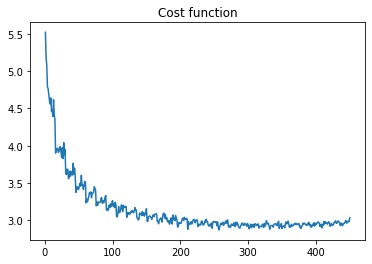

NN accuracy on training set 98.047%
NN accuracy on test set 44.100%


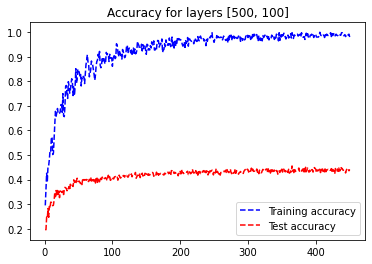

In [22]:
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [500, 100], N_epoch = 30, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=1, beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True,
         activ_func_hidden = 'relu', activ_out = 'softmax', loss_function ='cross-entropy')

L'algorithme fonctionne correctement et apprend. On remarque que l'on plafonne vite sur la précision obtenue sur l'échantillon test. Nous verrons par la suite si la régulation peut nous aider à solutionne ce problème.

 ## MSE et Sigmoid
 Testons le ensuite avec :
- Fonction d'activation des couches cachées : **Sigmoid**
- Fonction d'activation de la couche de sortie : **Sigmoid**
- Fonction de coût : **Mean Squared Error (mse)**
- Fonction d'optimisation : Adam
- Learning rate decay : Activé
- Terme de régulation : Lambda = 0.1
- Mini-batch size : 512

- Couches cachées : [500, 100]

2.886423705727327


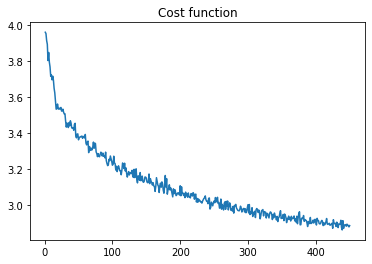

NN accuracy on training set 71.680%
NN accuracy on test set 39.550%


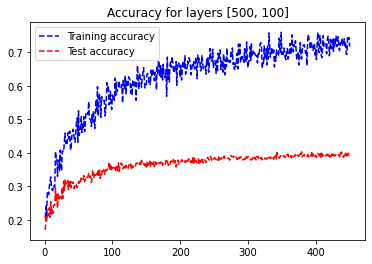

In [23]:
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [500, 100], N_epoch = 30, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=1, beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True,
         activ_func_hidden = 'sigmoid', activ_out = 'sigmoid', loss_function ='mse')

Pour les mêmes paramètres, le modèle apprend moins vite. On pouvait s'y attendre étant donné que la fonction sigmoid permet un apprentissage moins performant que la ReLU pour les couches cachées, en plus de demander plus de temps de calcul (du fait de la fonction exponentielle). Par ailleurs, la fonction sigmoid en sortie dans le cas d'une classification à plus de 2 classes n'est vraiment pas une bonne idée pour l'apprentissage. En effet cette fonction permettra moins la discrimination entre les sorties, avec des sorties dans la couche de sortie soit proche de 0, soit proche de 1. Cette proximité entre les valeurs complique l'apprentissage.

## Variation du nombre de couches cachées
 Testons le ensuite avec :
- Fonction d'activation des couches cachées : ReLU
- Fonction d'activation de la couche de sortie : Softmax
- Fonction de coût : Cross-Entropy
- Fonction d'optimisation : Adam
- Learning rate decay : Activé
- Mini-batch size : 512
- Terme de régulation : Lambda = 0.1
- Couches cachées testées : **[[25], [50], [100], [50, 30], [100, 30], [25, 30], [50, 100], [100, 100], [25, 100], [50, 100, 30], [100, 50, 30], [25, 50, 30, 10], [50, 40, 30, 40, 50, 30]]**

1.7243867364093064


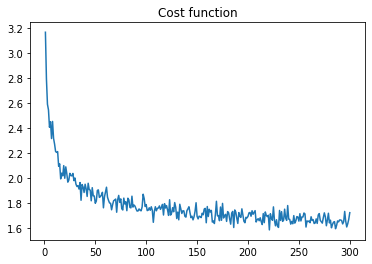

NN accuracy on training set 47.461%
NN accuracy on test set 38.000%


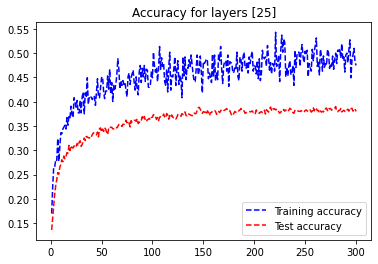

1.4836590519856814


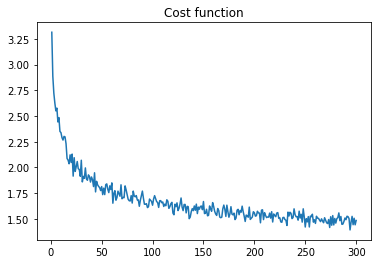

NN accuracy on training set 63.086%
NN accuracy on test set 39.650%


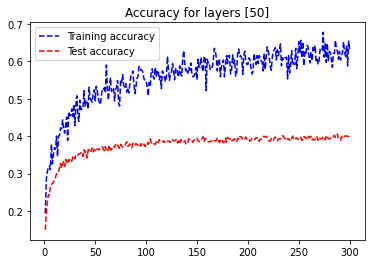

1.4916865310718879


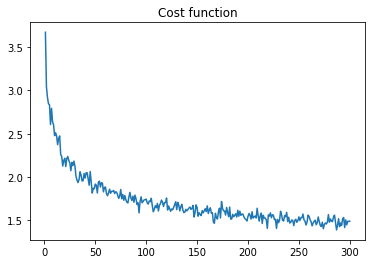

NN accuracy on training set 74.023%
NN accuracy on test set 42.050%


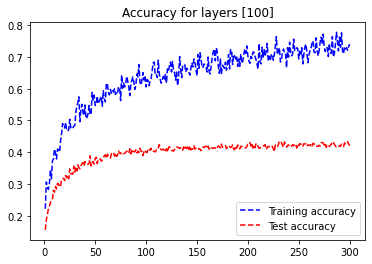

1.5765408247563237


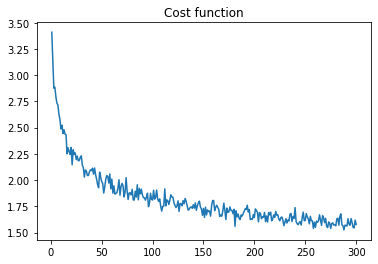

NN accuracy on training set 60.547%
NN accuracy on test set 38.700%


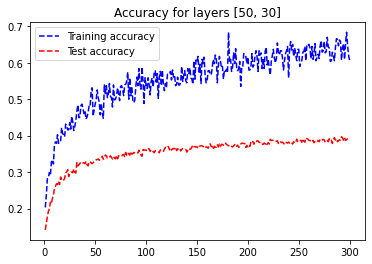

1.6419544889461268


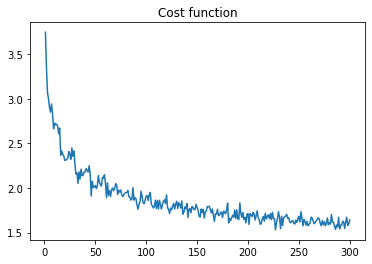

NN accuracy on training set 72.461%
NN accuracy on test set 41.500%


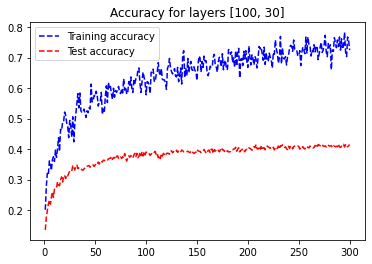

1.8730685114941443


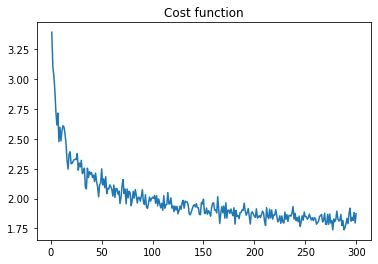

NN accuracy on training set 46.484%
NN accuracy on test set 35.950%


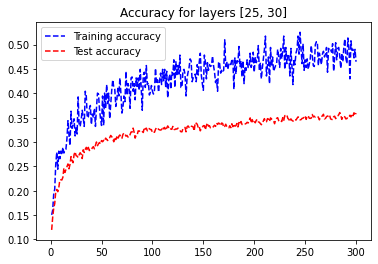

1.8631898568355192


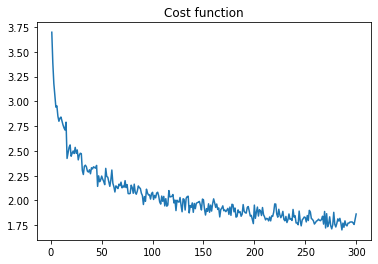

NN accuracy on training set 61.523%
NN accuracy on test set 38.650%


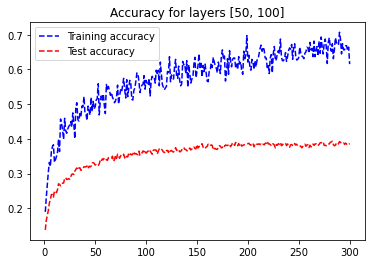

1.7462265515843889


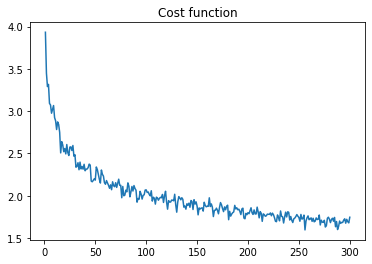

NN accuracy on training set 79.883%
NN accuracy on test set 41.200%


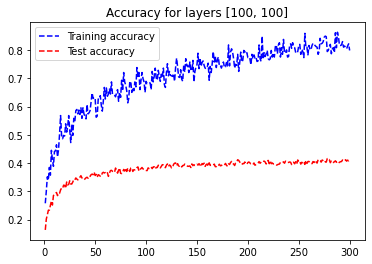

1.9219841247511391


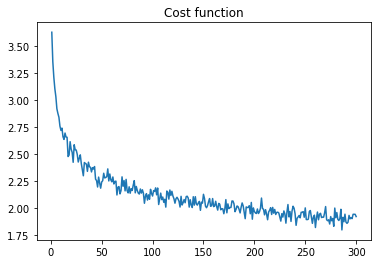

NN accuracy on training set 55.859%
NN accuracy on test set 37.600%


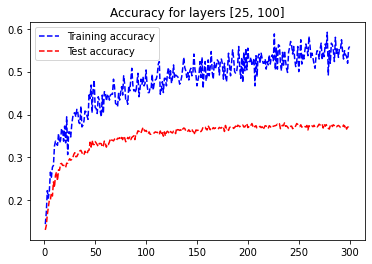

1.9161631132396526


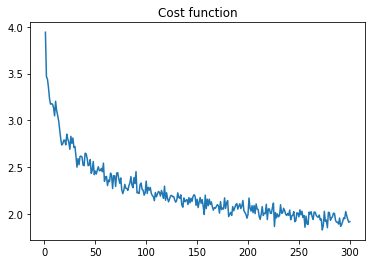

NN accuracy on training set 66.406%
NN accuracy on test set 36.550%


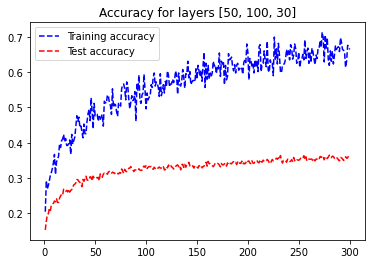

1.8461795556278338


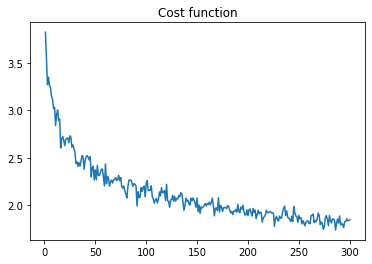

NN accuracy on training set 72.070%
NN accuracy on test set 39.050%


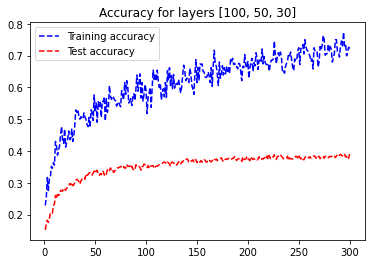

2.5880868490012423


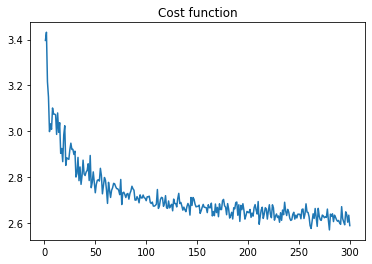

NN accuracy on training set 22.266%
NN accuracy on test set 16.050%


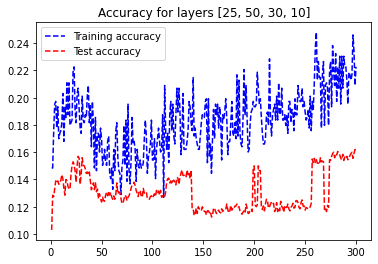

2.586548187924863


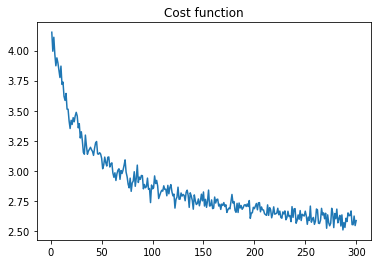

NN accuracy on training set 47.266%
NN accuracy on test set 30.650%


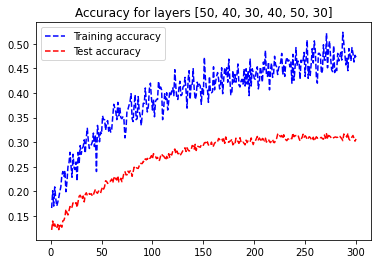

In [24]:
hidden_layers_list = [[25], [50], [100], [50, 30], [100, 30], [25, 30], [50, 100], [100, 100], [25, 100], 
                      [50, 100, 30], [100, 50, 30], [25, 50, 30, 10], [50, 40, 30, 40, 50, 30]]
for hidden_layers in hidden_layers_list:
    NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= hidden_layers, N_epoch = 20, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=1, beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True,
         activ_func_hidden = 'relu', activ_out = 'softmax', loss_function ='cross-entropy')

Après avoir testé ces différentes architectures, on peut en déduire que les architectures avec des largeurs de couche importantes semblent les plus performantes. Les structures profondes mais peu larges semblent au contraire apprendre difficilement. Nous allons donc refaire quelques tests en privilégiant ce genre de structures larges, bien que peu profondes.

1.713269941572984


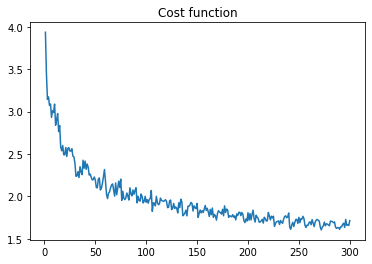

NN accuracy on training set 83.984%
NN accuracy on test set 43.700%


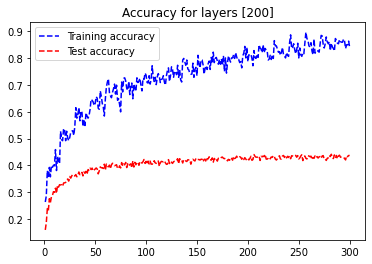

4.56371824516695


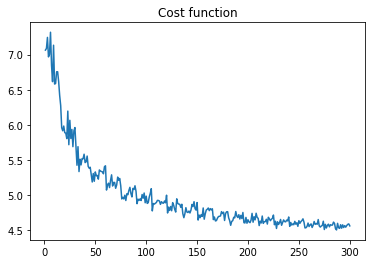

NN accuracy on training set 91.797%
NN accuracy on test set 41.350%


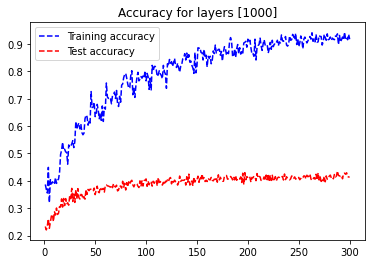

1.686800153487935


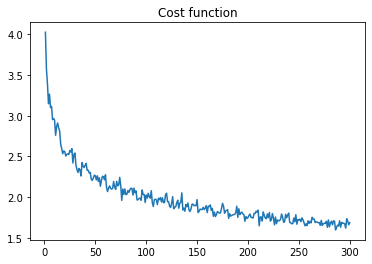

NN accuracy on training set 82.812%
NN accuracy on test set 40.900%


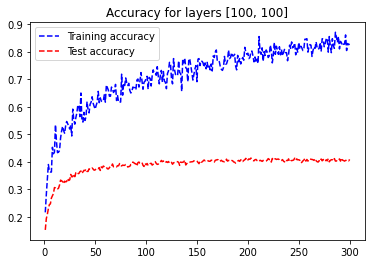

1.9442909355997582


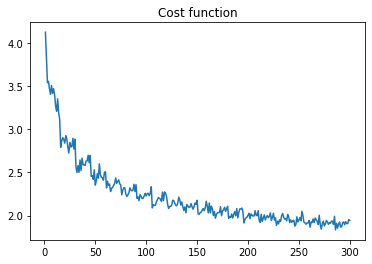

NN accuracy on training set 90.039%
NN accuracy on test set 41.650%


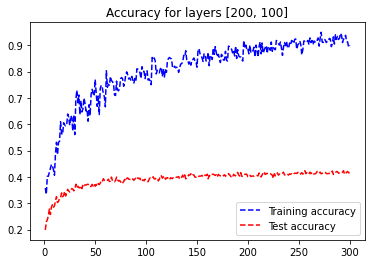

2.9395787351584644


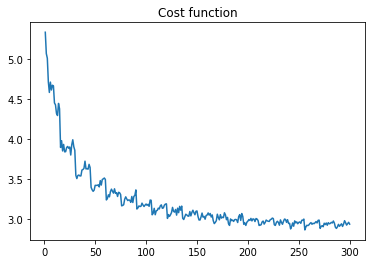

NN accuracy on training set 98.828%
NN accuracy on test set 44.750%


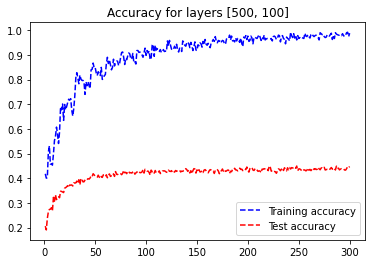

4.984139376131895


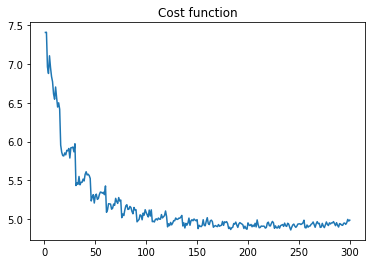

NN accuracy on training set 97.266%
NN accuracy on test set 42.200%


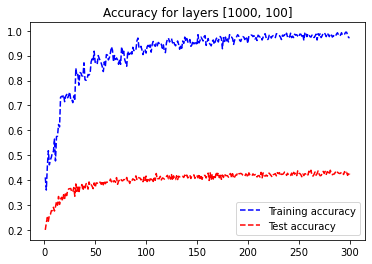

In [25]:
hidden_layers_list = [[200], [1000], [100, 100], [200, 100], [500, 100], [1000, 100]]
for hidden_layers in hidden_layers_list:
    NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= hidden_layers, N_epoch = 20, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=1, beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True,
         activ_func_hidden = 'relu', activ_out = 'softmax', loss_function ='cross-entropy')

Il semblerait qu'une structure de couches cachées de la forme [500,100] soit suffisante dans notre cas. C'est le choix que nous effectuerons pour la suite des tests. On remarque que notre algorithme plafonne dans tous les cas de figures à 40% de précision sur l'échantillon test.

## Influence du terme de régulation
 Testons le ensuite avec :
- Fonction d'activation des couches cachées : ReLU
- Fonction d'activation de la couche de sortie : Softmax
- Fonction de coût : Cross-Entropy
- Fonction d'optimisation : Adam
- Learning rate decay : Activé
- Mini-batch size : 512
- Terme de régulation : **Lambda = 0 (Pas de régulation) et Lambda = 10**
- Couches cachées : **[500, 100]** C'est l'architecture des couches cachées choisie pour la suite

0.28382888649997695


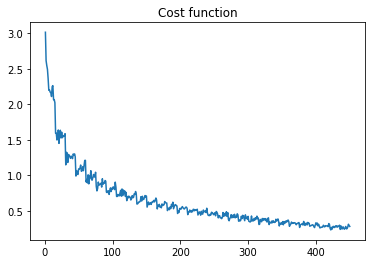

NN accuracy on training set 99.023%
NN accuracy on test set 42.700%


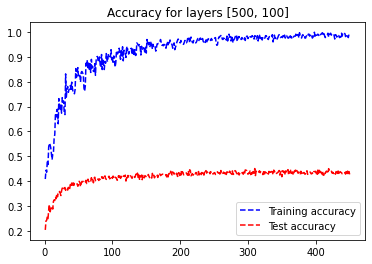

3.0111678952692094


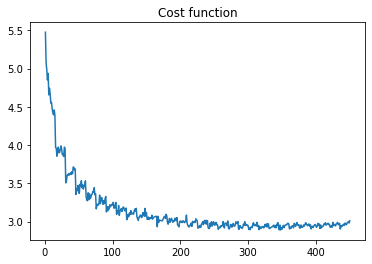

NN accuracy on training set 98.828%
NN accuracy on test set 43.200%


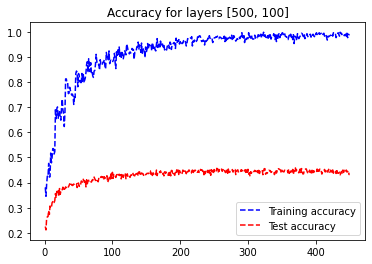

In [26]:
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [500, 100], N_epoch = 30, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=0, beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True,
         activ_func_hidden = 'relu', activ_out = 'softmax', loss_function ='cross-entropy')
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [500, 100], N_epoch = 30, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=1, beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True,
         activ_func_hidden = 'relu', activ_out = 'softmax', loss_function ='cross-entropy')

Avec un lambda (et donc un terme de régulation) non nul, on s'aperçoit qu'on améliore légèrement la précision sur le set de validation, au détriment (légèrement) de la précision sur le set d'entrainement. En bref, on lutte contre l'overfitting.

## Influence du learning rate decay :
 Testons le ensuite avec :
- Fonction d'activation des couches cachées : ReLU
- Fonction d'activation de la couche de sortie : Softmax
- Fonction de coût : Cross-Entropy
- Fonction d'optimisation : Adam
- Learning rate decay : **Désactivé**
- Mini-batch size : 512
- Terme de régulation : Lambda = 0.1
- Couches cachées : [500, 100]

2.9843653245648523


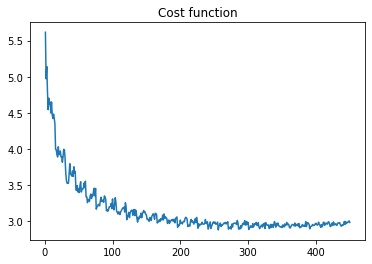

NN accuracy on training set 99.609%
NN accuracy on test set 44.000%


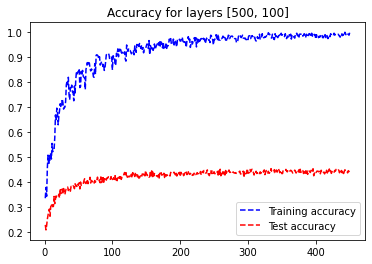

In [27]:
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [500, 100], N_epoch = 30, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=1, beta1=0.9, beta2 = 0.999, learning_r_dec= False, adam=True,
         activ_func_hidden = 'relu', activ_out = 'softmax', loss_function ='cross-entropy')

La méthode du learning rate decay permet de décroitre le learning rate au fur et à mesure des epochs. Cette méthode permet de faire tendre le lerning rate vers 0 et donc de mettre à jour les paramètres de manière plus précise, permettant d'obtenir une meilleure précision.

## Influence de l'optimisation d'Adam :
 Testons le ensuite avec :
- Fonction d'activation des couches cachées : ReLU
- Fonction d'activation de la couche de sortie : Softmax
- Fonction de coût : Cross-Entropy
- Fonction d'optimisation : **Classique**
- Learning rate decay : Activé
- Mini-batch size : 512
- Terme de régulation : Lambda = 1
- Couches cachées : [500, 100]

4.854213235579433


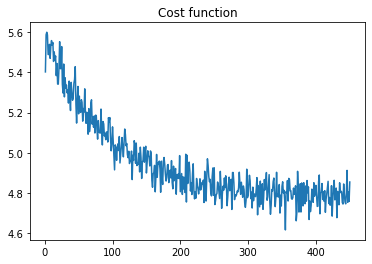

NN accuracy on training set 17.773%
NN accuracy on test set 19.300%


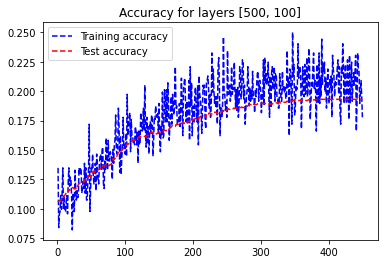

In [28]:
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [500, 100], N_epoch = 30, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=1, beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=False,
         activ_func_hidden = 'relu', activ_out = 'softmax', loss_function ='cross-entropy')

A learning rate (de départ) constant, l'optimisation d'Adam permet de mettre à jour les paramètre de manière plus pertinente. En effet on observe que le coût baisse assez peu, et que la précision de l'entrainement varie énormément. L'apprentissagee de manière générale semble plus chaotique.

## Utilisation de descripteurs :
 Testons le ensuite avec :
- Fonction d'activation des couches cachées : ReLU
- Fonction d'activation de la couche de sortie : Softmax
- Fonction de coût : Cross-Entropy
- Fonction d'optimisation : Adam
- Learning rate decay : Activé
- Mini-batch size : 512
- Terme de régulation : Lambda = 0.1
- Couches cachées : [500, 100]
- **Descripteur HOG**

2.994795693439363


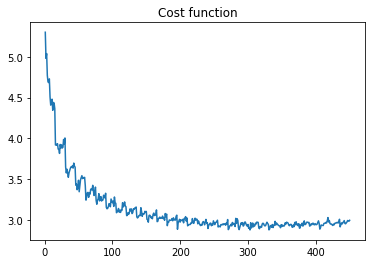

NN accuracy on training set 99.609%
NN accuracy on test set 44.900%


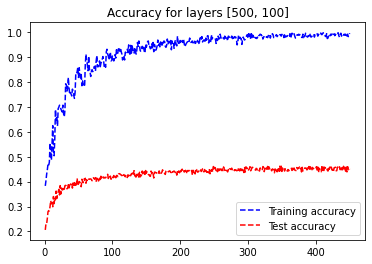

In [29]:
data_hog = transform_data_to_HOG(data)
X_train, Y_train, X_test_clean, Y_test_clean = preprocessing(data,labels)
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [500, 100], N_epoch = 30, batch_size = 512, 
         learning_rate= 0.0005, lambda_reg=1, beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True,
         activ_func_hidden = 'relu', activ_out = 'softmax', loss_function ='cross-entropy')

On s'aperçoit que la présence d'un descripteur HOG permet d'améliorer légèrement la précision du modèle sur le set de validation. C'est cohérent avec ce qui était espéré.

Pour conclure, on peut dire que malgré tous les éléments ajoutés pour améliorer la rapidité du modèle et sa précision, on ne dépasse jamais les 45% de précision sur le set de validation. On peut donc s'interroger sur la structure même du modèle, qui ne contient que des FCN (Fully-Connected Neurons). On verra dans la suite du cours que les CNN (Convolutionnal Neural Networks) sont plus pertinents pour ce qui est de la classification d'images. A noter que l'on a pas implémenté de *dropout* dans le réseau, qui aurait pu améliorer légèrement notre rapidité et/ou notre précision.